In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture



In [104]:
categorias=pd.read_csv("../data_raw/categorias.csv")
clientes=pd.read_csv("../data_raw/clientes.csv")
productos=pd.read_csv("../data_raw/productos.csv")
ventas=pd.read_csv("../data_raw/ventas.csv")
metodos_pago=pd.read_csv("../data_raw/metodos_pago.csv")
display(categorias.head())
display(clientes.head())
display(productos.head())
display(ventas.head())
display(metodos_pago.head())

,ID_Categoria,Categoría,Descripción
0,1,Lácteos,"Productos lácteos frescos y procesados, como l..."
1,2,Carnicería,"Carnes frescas y procesadas, como carne de vac..."
2,3,Panadería,"Productos horneados frescos, como pan, factura..."
3,4,Frutas y Verduras,"Frutas y verduras frescas, locales e importada..."
4,5,Congelados,"Productos congelados, como papas fritas, empan..."


,ID_Cliente,Nombre,Apellido,Email,Fecha_Resgistro,Región
0,1,Karisa,Cromett,kcromett0@imageshack.us,19/11/2023,Patagonia
1,2,Lenette,Seabert,lseabert1@yahoo.co.jp,07/05/2023,Patagonia
2,3,Buddy,Silverson,bsilverson2@howstuffworks.com,27/03/2023,Patagonia
3,4,Dan,Parkin,dparkin3@virginia.edu,26/10/2023,Buenos Aires
4,5,Conney,Cassella,ccassella4@who.int,31/03/2023,Centro


,ID_Producto,Nombre_producto,Categoría,Precio_Unitario,Stock
0,1,Leche,Lácteos,"12,24",3327
1,2,Yogur,Lácteos,"5,21",3358
2,3,Queso cremoso,Lácteos,"17,23",3167
3,4,Queso rallado,Lácteos,"19,23",2099
4,5,Manteca,Lácteos,"5,65",4929


,ID_Venta,Fecha,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado
0,919,31/01/2024,10,25,5,1,Completa
1,947,31/01/2024,106,5,1,4,Completa
2,1317,31/1/2024,235,25,3,3,Completa
3,1607,31/1/2024,114,15,5,1,Completa
4,2038,31/1/2024,132,2,5,4,Completa


,ID_Metodo,Método,Descripción
0,1,Efectivo,"Pago en dinero en efectivo, sin intermediarios..."
1,2,Tarjeta de Crédito,Pago con tarjetas emitidas por bancos y financ...
2,3,Tarjeta de Débito,Pago con tarjetas que debitán directamente de ...
3,4,Mercado Pago,Plataforma de pagos online que permite realiza...
4,5,Transferencia,Pago realizado a través de una transferencia d...


In [105]:
productos["Precio_Unitario"]=productos["Precio_Unitario"].str.replace(",",".").astype(float)

In [106]:
df=ventas.merge(clientes, on="ID_Cliente",how="inner")
df.drop(columns=["Email"],inplace=True)
df = df.merge(productos[["ID_Producto", "Precio_Unitario"]], on="ID_Producto", how="inner")
df["Cantidad_dinero"]=df["Cantidad"]*df["Precio_Unitario"]
df

,ID_Venta,Fecha,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado,Nombre,Apellido,Fecha_Resgistro,Región,Precio_Unitario,Cantidad_dinero
0,919,31/01/2024,10,25,5,1,Completa,Stephenie,Sexty,23/11/2023,Buenos Aires,15.45,77.25
1,947,31/01/2024,106,5,1,4,Completa,Benedikta,Condon,23/06/2023,NEA,5.65,5.65
2,1317,31/1/2024,235,25,3,3,Completa,Cloe,Brun,11/12/2023,NEA,15.45,46.35
3,1607,31/1/2024,114,15,5,1,Completa,Fabien,Roskam,11/04/2023,Centro,3.51,17.55
4,2038,31/1/2024,132,2,5,4,Completa,Cassie,Corish,14/12/2023,Buenos Aires,5.21,26.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024,954,30/12/2024,44,12,6,4,Completa,Cyrill,Runge,17/09/2023,Buenos Aires,8.12,48.72
3025,1390,30/12/2024,26,31,3,4,Completa,Byrom,Soro,05/07/2023,Centro,5.24,15.72
3026,1519,30/12/2024,246,11,3,3,Completa,Almira,Zottoli,28/09/2023,NEA,11.23,33.69
3027,2147,30/12/2024,231,22,2,1,Pendiente,Rani,Chattelaine,13/12/2023,Patagonia,4.21,8.42


In [107]:
# Detección de outliers en Precio_Unitario 
Q1 = df["Precio_Unitario"].quantile(0.25)
Q3 = df["Precio_Unitario"].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df["Precio_Unitario"] < Q1 - 1.5 * IQR) | (df["Precio_Unitario"] > Q3 + 1.5 * IQR)]
print(f"Outliers detectados en Precio_Unitario: {len(outliers)}")

Outliers detectados en Precio_Unitario: 81


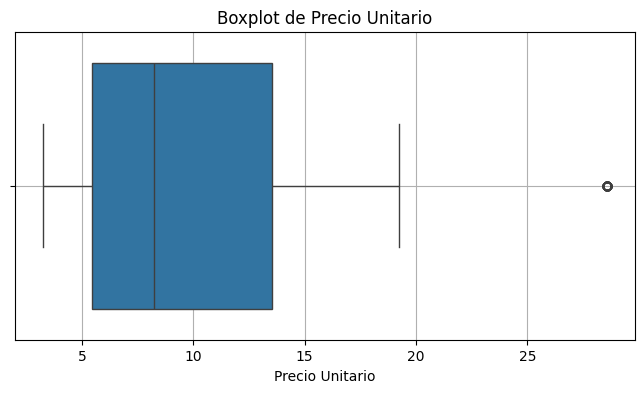

In [108]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["Precio_Unitario"])
plt.title("Boxplot de Precio Unitario")
plt.xlabel("Precio Unitario")
plt.grid(True)
plt.show()

In [109]:
outlier_counts = outliers["ID_Producto"].value_counts()
print(outlier_counts.head(10))


ID_Producto
6    81
Name: count, dtype: int64


In [110]:
outliers = outliers.merge(productos[["ID_Producto", "Nombre_producto"]], on="ID_Producto", how="left")
print(outliers[["ID_Producto", "Nombre_producto", "Precio_Unitario"]].sort_values(by="Precio_Unitario"))

# No es outlier realmente es un producto costoso, por lo cual no lo eliminamos.


    ID_Producto Nombre_producto  Precio_Unitario
0             6           Asado            28.56
57            6           Asado            28.56
56            6           Asado            28.56
55            6           Asado            28.56
54            6           Asado            28.56
..          ...             ...              ...
23            6           Asado            28.56
22            6           Asado            28.56
21            6           Asado            28.56
39            6           Asado            28.56
80            6           Asado            28.56

[81 rows x 3 columns]


In [111]:
df=df.merge(productos[["ID_Producto","Stock"]], on="ID_Producto", how="inner")

In [112]:
df = df.merge(productos[["ID_Producto", "Categoría"]], on="ID_Producto", how="left")
ventas_categoria = df.groupby("Categoría")["Cantidad_dinero"].sum()

In [113]:
dict_stock=productos.set_index("ID_Producto")["Stock"].to_dict()
print(dict_stock)
cantidad_de_producto_actual=[]
for cantidad, id_producto in zip(df["Cantidad"], df["ID_Producto"]):
    dict_stock[id_producto]-=cantidad
    cantidad_de_producto_actual.append(dict_stock[id_producto])
    if dict_stock[id_producto]<=0:
        print(f"Stock acabado para el producto {id_producto}")
print(dict_stock)
df["Producto_actual_stock"]=cantidad_de_producto_actual
df

{1: 3327, 2: 3358, 3: 3167, 4: 2099, 5: 4929, 6: 5137, 7: 4068, 8: 3140, 9: 4051, 10: 2429, 11: 1726, 12: 1619, 13: 2228, 14: 3125, 15: 4043, 16: 3189, 17: 3383, 18: 4720, 19: 4041, 20: 1541, 21: 2800, 22: 3545, 23: 3731, 24: 2908, 25: 1640, 26: 1688, 27: 4978, 28: 3637, 29: 2455, 30: 1363, 31: 2771, 32: 5057, 33: 2837, 34: 4769, 35: 1437, 36: 4578, 37: 1506, 38: 2182}
{1: 3051, 2: 3085, 3: 2894, 4: 1840, 5: 4629, 6: 4838, 7: 3775, 8: 2820, 9: 3799, 10: 2174, 11: 1472, 12: 1319, 13: 1969, 14: 2908, 15: 3779, 16: 2959, 17: 3084, 18: 4506, 19: 3793, 20: 1314, 21: 2534, 22: 3320, 23: 3426, 24: 2631, 25: 1308, 26: 1306, 27: 4620, 28: 3409, 29: 2102, 30: 1120, 31: 2471, 32: 4725, 33: 2605, 34: 4487, 35: 1131, 36: 4362, 37: 1249, 38: 1861}


,ID_Venta,Fecha,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado,Nombre,Apellido,Fecha_Resgistro,Región,Precio_Unitario,Cantidad_dinero,Stock,Categoría,Producto_actual_stock
0,919,31/01/2024,10,25,5,1,Completa,Stephenie,Sexty,23/11/2023,Buenos Aires,15.45,77.25,1640,Congelados,1635
1,947,31/01/2024,106,5,1,4,Completa,Benedikta,Condon,23/06/2023,NEA,5.65,5.65,4929,Lácteos,4928
2,1317,31/1/2024,235,25,3,3,Completa,Cloe,Brun,11/12/2023,NEA,15.45,46.35,1640,Congelados,1632
3,1607,31/1/2024,114,15,5,1,Completa,Fabien,Roskam,11/04/2023,Centro,3.51,17.55,4043,Panadería,4038
4,2038,31/1/2024,132,2,5,4,Completa,Cassie,Corish,14/12/2023,Buenos Aires,5.21,26.05,3358,Lácteos,3353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024,954,30/12/2024,44,12,6,4,Completa,Cyrill,Runge,17/09/2023,Buenos Aires,8.12,48.72,1619,Panadería,1319
3025,1390,30/12/2024,26,31,3,4,Completa,Byrom,Soro,05/07/2023,Centro,5.24,15.72,2771,Galletitas y Snacks,2471
3026,1519,30/12/2024,246,11,3,3,Completa,Almira,Zottoli,28/09/2023,NEA,11.23,33.69,1726,Carnicería,1472
3027,2147,30/12/2024,231,22,2,1,Pendiente,Rani,Chattelaine,13/12/2023,Patagonia,4.21,8.42,3545,Frutas y Verduras,3320


In [114]:
productos_vendidos=df.groupby("ID_Producto")["Producto_actual_stock"].min().reset_index()
productos_vendidos=productos_vendidos.merge(productos[["ID_Producto","Stock"]], on="ID_Producto", how="inner")
productos_vendidos["Cantidad_vendida"]=productos_vendidos["Stock"]-productos_vendidos["Producto_actual_stock"]
productos_vendidos.sort_values("Cantidad_vendida", ascending=False).reset_index(drop=True)

,ID_Producto,Producto_actual_stock,Stock,Cantidad_vendida
0,26,1306,1688,382
1,27,4620,4978,358
2,29,2102,2455,353
3,32,4725,5057,332
4,25,1308,1640,332
5,38,1861,2182,321
6,8,2820,3140,320
7,35,1131,1437,306
8,23,3426,3731,305
9,31,2471,2771,300


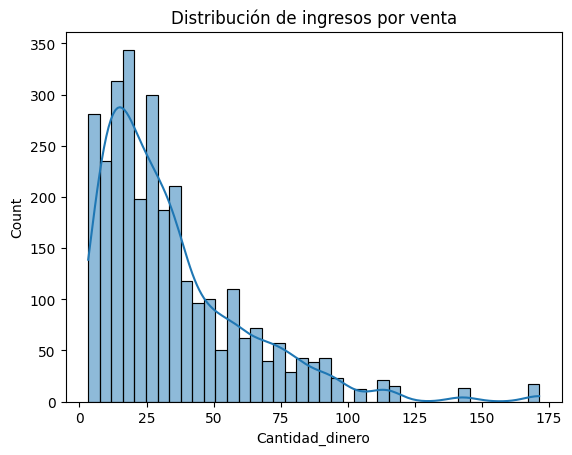

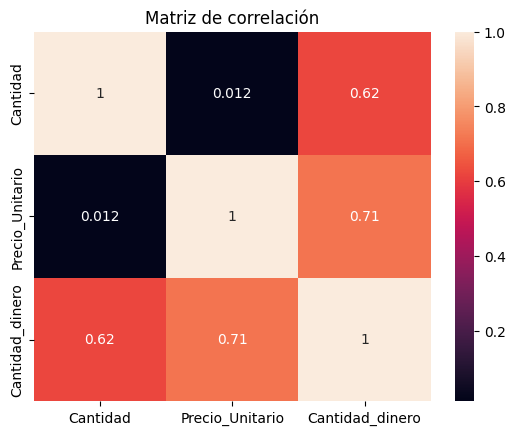

In [115]:
# Distribución de ingresos por venta
sns.histplot(df["Cantidad_dinero"], kde=True)
plt.title("Distribución de ingresos por venta")
plt.xlabel("Cantidad_dinero")
plt.show()

# Correlaciones entre variables numéricas
sns.heatmap(df[["Cantidad", "Precio_Unitario", "Cantidad_dinero"]].corr(), annot=True)
plt.title("Matriz de correlación")
plt.show()

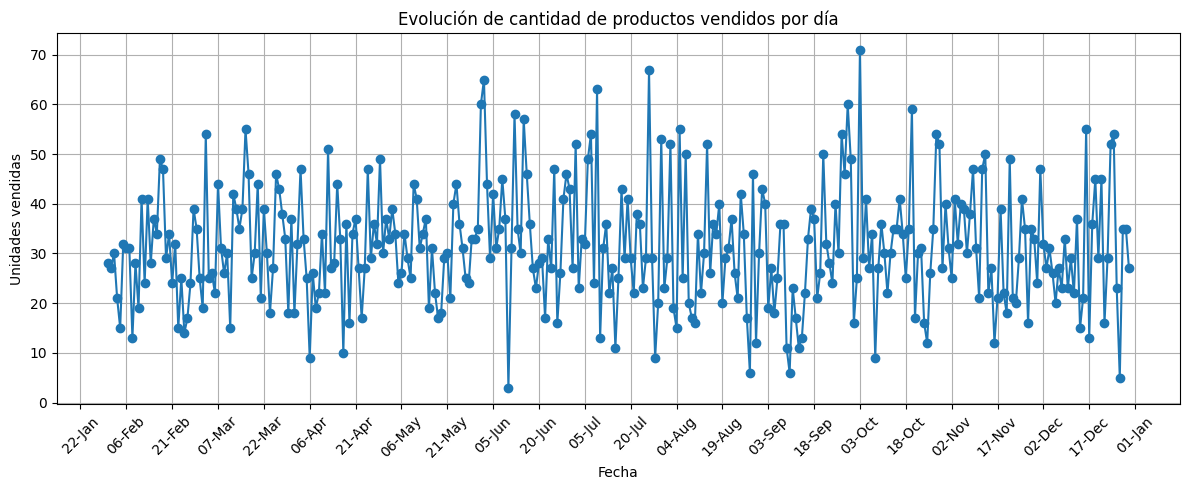

In [116]:

ventas["Fecha"] = pd.to_datetime(ventas["Fecha"], format="%d/%m/%Y")
ventas_diarias = ventas.groupby("Fecha")[["Cantidad"]].sum().reset_index()


plt.figure(figsize=(12, 5))
plt.plot(ventas_diarias["Fecha"], ventas_diarias["Cantidad"], marker='o')
plt.title("Evolución de cantidad de productos vendidos por día")
plt.xlabel("Fecha")
plt.ylabel("Unidades vendidas")
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [117]:
print(ventas.columns)


Index(['ID_Venta', 'Fecha', 'ID_Cliente', 'ID_Producto', 'Cantidad',
       'Método_Pago', 'Estado'],
      dtype='object')


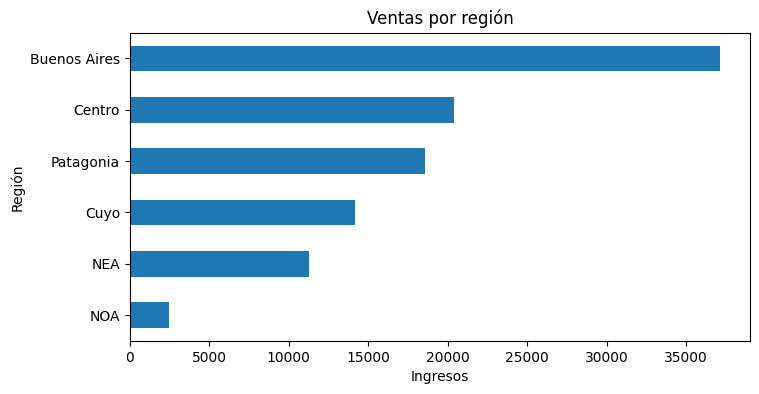

In [118]:
# Ventas por región 
df.groupby("Región")["Cantidad_dinero"].sum().sort_values().plot(kind="barh", title="Ventas por región", figsize=(8,4))
plt.xlabel("Ingresos")
plt.show()

In [119]:
print(productos.columns)


Index(['ID_Producto', 'Nombre_producto', 'Categoría', 'Precio_Unitario',
       'Stock'],
      dtype='object')


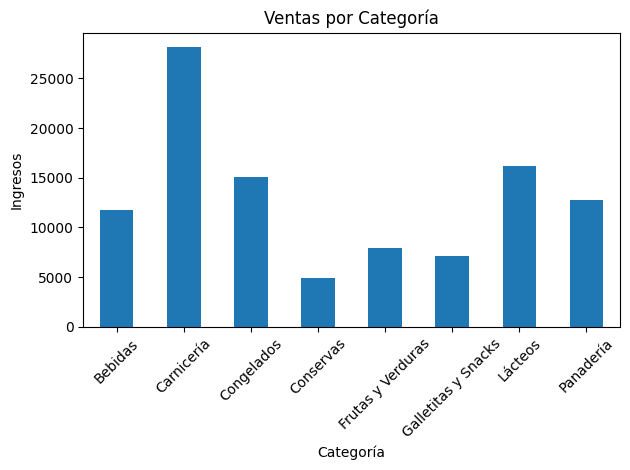

In [120]:
# --- Ventas por categoría ---
ventas_categoria.plot(kind="bar", title="Ventas por Categoría")
plt.ylabel("Ingresos")
plt.xlabel("Categoría")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


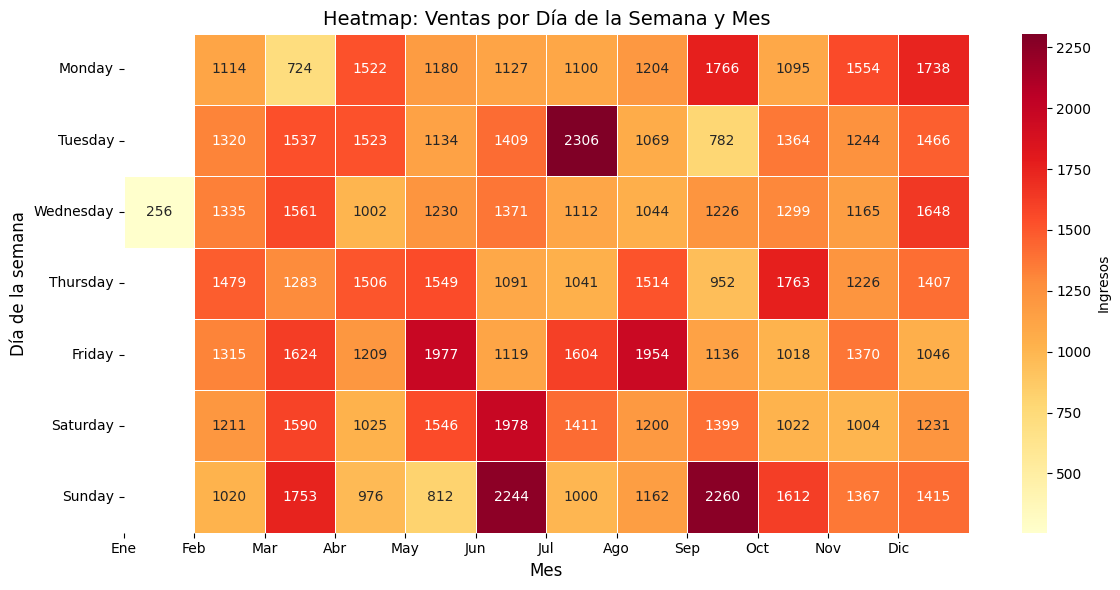

In [121]:

df["Fecha"] = pd.to_datetime(df["Fecha"], format="%d/%m/%Y")
df["Día_semana"] = df["Fecha"].dt.day_name()
df["Mes"] = df["Fecha"].dt.month


heatmap_data = df.groupby(["Día_semana", "Mes"])["Cantidad_dinero"].sum().unstack()


dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(dias_orden)


plt.figure(figsize=(12, 6))  

sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"label": "Ingresos"}
)

plt.title("Heatmap: Ventas por Día de la Semana y Mes", fontsize=14)
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Día de la semana", fontsize=12)

plt.xticks(ticks=range(12), labels=[
    'Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'
], rotation=0)

plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [122]:
productos_vendidos_sorted = productos_vendidos.sort_values("Cantidad_vendida", ascending=False)
fig = go.Figure()

fig.add_trace(go.Bar(
    x=productos_vendidos_sorted["ID_Producto"].astype(str),
    y=productos_vendidos_sorted["Stock"],
    name="Stock Total",
    opacity=1
))


fig.add_trace(go.Bar(
    x=productos_vendidos_sorted["ID_Producto"].astype(str),
    y=productos_vendidos_sorted["Producto_actual_stock"],
    name="Stock Restante",
    opacity=1
))

fig.update_layout(
    title="Stock Total vs Stock Restante por Producto",
    xaxis_title="ID Producto",
    yaxis_title="Cantidad",
    barmode='overlay',
    width=1000,
    height=600

)

fig.show()

In [123]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=productos_vendidos_sorted["ID_Producto"].astype(str),
    y=productos_vendidos_sorted["Cantidad_vendida"],
    name="Cantidad Vendida",
    marker=dict(
        color=productos_vendidos_sorted["Cantidad_vendida"],
        colorscale='Inferno',
        showscale=True,
        colorbar=dict(title="Cantidad")
    ),
    opacity=1
))

fig.update_layout(
    title="Cantidad Vendida por Producto",
    xaxis_title="ID Producto",
    yaxis_title="Cantidad Vendida",
    width=1000,
    height=600
)

fig.show()

## 4.4 Segmentación y Clustering (peso alto)

In [124]:
# Preparar datos para clustering
cluster_data = productos_vendidos[['Cantidad_vendida', 'Stock', 'Producto_actual_stock']].copy()
cluster_data["Porcentaje_venta"] = (cluster_data["Cantidad_vendida"] / cluster_data["Stock"]) * 100


In [125]:
#  Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_data)

In [126]:
# Evaluar número óptimo de clusters
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

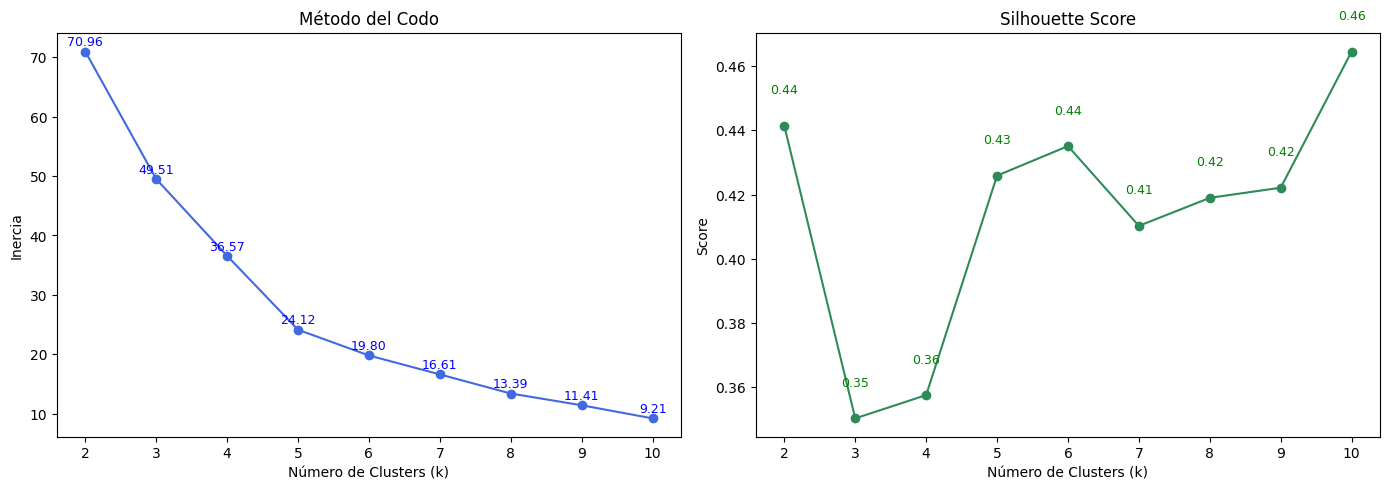

In [127]:
plt.figure(figsize=(14, 5))

# Gráfico del Método del Codo
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o', linestyle='-', color='royalblue')
plt.title("Método del Codo")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia")


for i, (k, inertia) in enumerate(zip(K_range, inertias)):
    plt.text(k, inertia + 1, f"{inertia:.2f}", ha='center', fontsize=9, color='blue')

# Gráfico del Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouettes, marker='o', linestyle='-', color='seagreen')
plt.title("Silhouette Score")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Score")


for i, (k, score) in enumerate(zip(K_range, silhouettes)):
    plt.text(k, score + 0.01, f"{score:.2f}", ha='center', fontsize=9, color='green')

plt.tight_layout()
plt.show()





Para seleccionar el número óptimo de clústeres ($k$), hemos evaluado dos métricas clave: el **Método del Codo (Inercia)** y el **Coeficiente de Silhouette**.

* El gráfico de **Inercia** muestra una fuerte caída en la varianza dentro de los grupos hasta llegar a **$k=4$**, indicando que la mayor parte de la información se agrupa eficientemente en este punto .
* Aunque el **Coeficiente de Silhouette** alcanza su máximo en $k=10$, un $k$ tan alto resulta poco práctico para el análisis de negocio y la interpretación de los patrones de demanda. Por lo tanto, seleccionamos **$k=4$**  que tiene el segundo valor más alto.

 Este valor representa el mejor  equilibrio entre los dos métodos .